# Implementacja struktury danych KD-Tree

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer

### Funkcje służące do generowania zbiorów testowych

In [ ]:
def generate_random_uniform_points(n, low, high):
    points = []
    for i in range(n):
        points.append((np.random.uniform(low, high),np.random.uniform(low, high)))
    return points

In [2]:
def interactive_add_points(given_points=None):
    if given_points is not None:
        points = given_points
    points = []

    def on_click(event):
        if event.button == 1 and event.inaxes and event.dblclick:
            x, y = event.xdata, event.ydata
            points.append((x, y))
            ax.plot(x, y, 'ro')
            plt.draw()


        elif event.button == 3 and event.dblclick:
            fig.canvas.mpl_disconnect(cid)
            ax.set_title("Rysowanie zakończone. Punkty zapisane.")
            plt.draw()
            plt.pause(1)
            plt.close()
            return points
    fig, ax = plt.subplots()
    ax.set_title(
        "Lewy podwójny click dodaje punkt,\n Prawy podwójny click kończy rysowanie."
    )
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axhline(0, color="black", linewidth=0.5)
    ax.axvline(0, color="black", linewidth=0.5)
    ax.grid(color="gray", linestyle="--", linewidth=0.5)

    cid = fig.canvas.mpl_connect("button_press_event", on_click)

    plt.show()
    return points

## Implementacja struktury KD-Tree

### funkcja quicksort używana do wstępnego sortowania punktów

In [5]:
def partition_hoare(arr,l,r,dim):
    pivot = arr[l][dim]
    i = l-1
    j = r+1
    while True:
        i+=1
        while arr[i][dim] < pivot:
            i+=1
        j-=1
        while arr[j][dim] > pivot:
            j-=1
        if i>=j:
            return j
        arr[i],arr[j] = arr[j],arr[i]


def quicksort(arr,l,r,dim):
    if l<r:
        q = partition_hoare(arr,l,r,dim)
        quicksort(arr,l,q,dim)
        quicksort(arr,q+1,r,dim)

### Implementacja klasy KDTree

In [7]:
class KDtree:
    class Vertex:
        def __init__(self, point, left=None, right=None):
            self.divider = point
            self.left = None
            self.right = None

        def getclass(self):
            return self.__class__

    class Leaf:
        def __init__(self, point):
            self.point = point

        def getclass(self):
            return self.__class__

    def __init__(self,points):
        new_points = []
        for i in range(2):
            new_points.append(self.sort_by_dim(points,i))
        self.root = self.build_tree(new_points,0)


    def get_root(self):
        return self.root

    @staticmethod
    def sort_by_dim(points, dim):
        sorted_points = points[:]
        quicksort(sorted_points, 0, len(points) - 1, dim)
        return sorted_points

    def divide_points(self,points,dim):
        if not points[dim]:
            return None
        if len(points[dim]) == 1:
            return points[dim][0], [], []
        median = points[dim][(len(points[dim])-1) // 2][dim]
        median_point = points[dim][(len(points[dim])-1) // 2]
        left = []
        right = []
        for i in range(2):
            left_points = [point for point in points[i] if point[dim] <= median]
            right_points = [point for point in points[i] if point[dim] > median]
            left.append(left_points)
            right.append(right_points)
        return median_point, left, right

    def build_tree(self,points,depth):
        dim = depth % 2
        if len(points[dim]) == 1:
            return self.Leaf(points[dim][0])
        division = self.divide_points(points,dim)
        if division:
            median, left, right = division
        else:
            return None
        root = self.Vertex(median[dim])
        root.left = self.build_tree(left,depth+1)
        root.right = self.build_tree(right,depth+1)
        return root


    def search_area(self,area,root,depth):
        if root is None:
            return []
        left = []
        right = []
        if root.getclass() == self.Vertex:
            dim = depth % 2
            if area[0][dim] <= root.divider:
                left = self.search_area(area,root.left,depth+1)
            else:
                left = []
            if area[1][dim] >= root.divider:
                right = self.search_area(area,root.right,depth+1)
            else:
                right = []
        else:
            if root.getclass() == self.Leaf and area[0][0] <= root.point[0] <= area[1][0] and area[0][1] <= root.point[1] <= area[1][1]:
                return left + [root.point] + right
        return left + right

### Wizualizacja drzewa KD-Tree



In [13]:
class KDtree_w_visualization:
    class Vertex:
        def __init__(self, point, left=None, right=None):
            self.divider = point
            self.left = None
            self.right = None

        def getclass(self):
            return self.__class__

    class Leaf:
        def __init__(self, point):
            self.point = point

        def getclass(self):
            return self.__class__

    def __init__(self,points):
        self.vis = Visualizer()
        self.vis.add_point(points)
        new_points = []
        for i in range(2):
            new_points.append(self.sort_by_dim(points,i))
        self.root = self.build_tree(new_points,0,self.vis)

    def visualize(self):
        return self.vis.show()


    def get_root(self):
        return self.root

    @staticmethod
    def sort_by_dim(points, dim):
        sorted_points = points[:]
        quicksort(sorted_points, 0, len(points) - 1, dim)
        return sorted_points

    def divide_points(self,points,dim):
        if not points[dim]:
            return None
        if len(points[dim]) == 1:
            return points[dim][0], [], []
        median = points[dim][(len(points[dim])-1) // 2][dim]
        median_point = points[dim][(len(points[dim])-1) // 2]
        left = []
        right = []
        for i in range(2):
            left_points = [point for point in points[i] if point[dim] <= median]
            right_points = [point for point in points[i] if point[dim] > median]
            left.append(left_points)
            right.append(right_points)
        return median_point, left, right

    def build_tree(self,points,depth,vis):
        dim = depth % 2
        if len(points[dim]) == 1:
            return self.Leaf(points[dim][0])
        division = self.divide_points(points,dim)
        if division:
            median, left, right = division
        else:
            return None
        root = self.Vertex(median[dim])
        if dim == 0:
            vis.add_line([(0,median[dim]),(10,median[dim)],color = 'blue')
        else:
            vis.add_line([(median[dim],0),(median[dim],10)],color = 'blue')
        root.left = self.build_tree(left,depth+1,vis)
        root.right = self.build_tree(right,depth+1,vis)
        return root


    def search_area(self,area,root,depth):
        if root is None:
            return []
        left = []
        right = []
        if root.getclass() == self.Vertex:
            dim = depth % 2
            if area[0][dim] <= root.divider:
                left = self.search_area(area,root.left,depth+1)
            else:
                left = []
            if area[1][dim] >= root.divider:
                right = self.search_area(area,root.right,depth+1)
            else:
                right = []
        else:
            if root.getclass() == self.Leaf and area[0][0] <= root.point[0] <= area[1][0] and area[0][1] <= root.point[1] <= area[1][1]:
                return left + [root.point] + right
        return left + right

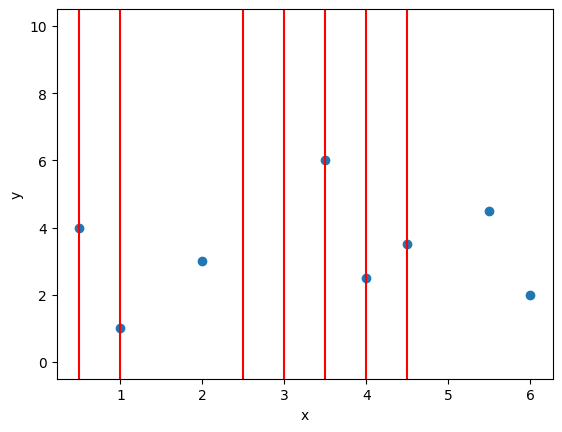

In [14]:
test_data = [(1,1),(2,3),(0.5,4),(5.5,4.5),(6,2),(4,2.5),(3.5,6),(4.5,3.5)]
kdtree = KDtree_w_visualization(test_data)
kdtree.visualize()